In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/kiselev1189/face-detector-s3fd
from sfd_face_detector.detect_engine import FaceDetectionEngine

# S3FD  Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class S3fdDetector(Detector):
    def __init__(self):
        self.detector = FaceDetectionEngine(weights_path="./models/s3fd/s3fd_convert.pth")
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Running on device: {}'.format(device))
        
    def detect(self, image):
        preds, scores = self.detector.predict(image, dilate_bbox=False)

        return preds, scores

s3fd = S3fdDetector()

Running on device: cpu


In [4]:
with TsvHandle('s3fd') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = s3fd
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [3226/3226]
./results/s3fd-20220616-212233.tsv
./results/s3fd-20220616-212233-ap.tsv
./results/s3fd-20220616-212233-load.tsv
./results/s3fd-20220616-212233-metadata.tsv


In [5]:
with TsvHandle('s3fd_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = s3fd, 
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [3226/3226]
./results/s3fd_filtered-20220616-235349.tsv
./results/s3fd_filtered-20220616-235349-ap.tsv
./results/s3fd_filtered-20220616-235349-load.tsv
./results/s3fd_filtered-20220616-235349-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-16 21:22:33.131653,0.1,5152014336
1,2022-06-16 21:22:46.157773,48.8,4691419136
2,2022-06-16 21:22:58.125772,51.8,4652994560
3,2022-06-16 21:23:11.179270,51.8,4703797248
4,2022-06-16 21:23:23.686270,52.1,4663742464
...,...,...,...
715,2022-06-16 23:52:40.027322,51.2,4795609088
716,2022-06-16 23:52:53.552324,51.5,4817793024
717,2022-06-16 23:53:06.115323,45.0,4822065152
718,2022-06-16 23:53:19.642322,52.1,4807286784


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

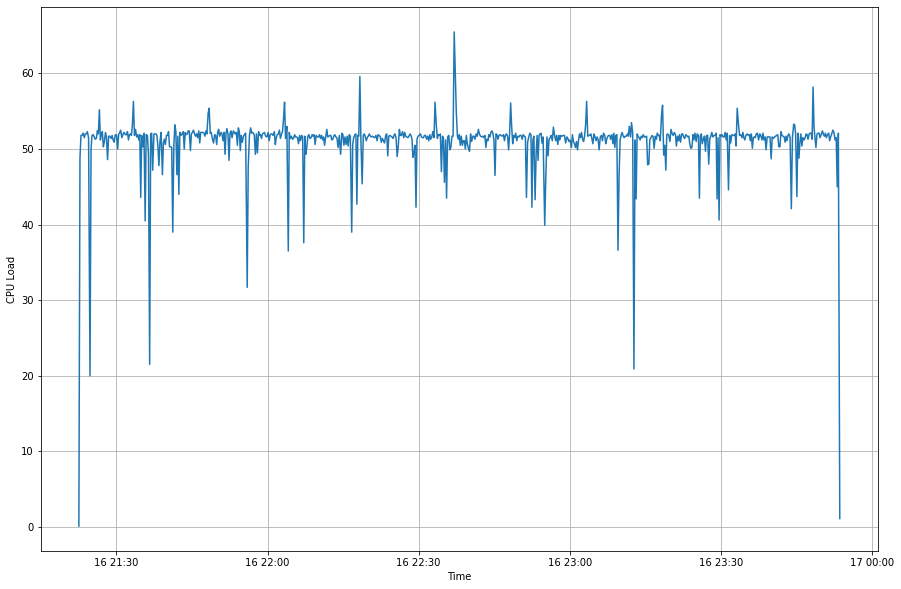

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

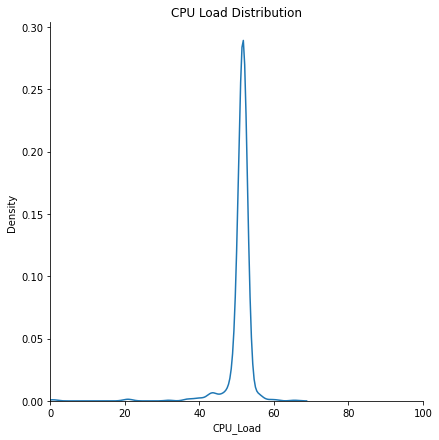

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

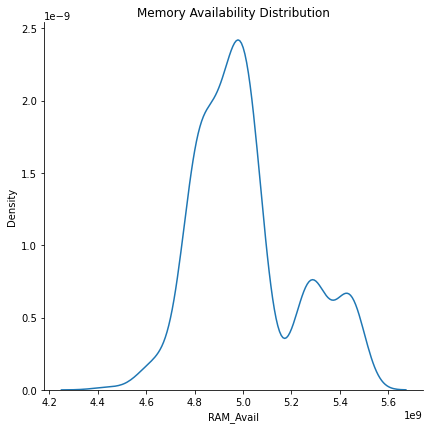

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-16 21:22:36.085272,2383294400,1.000000,1.000000,1.000000,"[0.9082491582491582, 0.9106326219512195, 0.923...",8,0,0,8,"[(909.0, 330.0, 975.0, 420.0), (717.0, 229.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-16 21:22:40.745771,4655337200,1.000000,1.000000,1.000000,[0.8413917758698599],1,0,0,1,"[(555.0, 1231.0, 695.0, 1329.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-06-16 21:22:42.878771,2125615700,1.000000,1.000000,1.000000,"[0.7413652434049497, 0.910828025477707]",2,0,0,2,"[(557.0, 115.0, 604.0, 174.0), (458.0, 46.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-06-16 21:22:46.157773,3143140300,1.000000,0.112903,0.202899,"[0.7245508982035929, 0.8570287539936102, 0.770...",7,0,55,62,"[(256.0, 496.0, 290.0, 540.0), (288.0, 431.0, ...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-06-16 21:22:48.043270,1865275100,1.000000,1.000000,1.000000,"[0.8683905827865689, 0.9119380987472365, 0.731...",8,0,0,8,"[(201.0, 76.0, 248.0, 129.0), (272.0, 70.0, 31...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-06-16 23:53:14.914823,4835029200,1.000000,1.000000,1.000000,[0.8202566140570001],1,0,0,1,"[(458.0, 159.0, 594.0, 327.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-06-16 23:53:19.642322,4719921100,1.000000,1.000000,1.000000,"[0.8058540200074101, 0.7615869484612533]",2,0,0,2,"[(715.0, 420.0, 797.0, 536.0), (330.0, 416.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-06-16 23:53:22.279822,2533977100,0.931034,1.000000,0.964286,"[0.918918918918919, 0.9393939393939394, 0.7873...",27,2,0,27,"[(678.0, 490.0, 709.0, 526.0), (69.0, 307.0, 1...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-06-16 23:53:24.187822,1890529100,1.000000,0.857143,0.923077,"[0.9076054664289959, 0.7972865123703112, 0.831...",6,0,1,7,"[(854.0, 78.0, 901.0, 143.0), (753.0, 64.0, 78...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.756172e+09,0.888749,0.738164,0.769469,5.127092,0.266894,7.181649,12.308741
std,1.044082e+09,0.270083,0.346100,0.311229,11.299144,0.869679,31.995114,39.822258
min,6.984005e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.114466e+09,1.000000,0.500000,0.626426,1.000000,0.000000,0.000000,1.000000
50%,2.340976e+09,1.000000,1.000000,0.975610,2.000000,0.000000,0.000000,3.000000
75%,3.148982e+09,1.000000,1.000000,1.000000,5.000000,0.000000,3.000000,9.000000
max,1.611914e+10,1.000000,1.000000,1.000000,204.000000,17.000000,584.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count     3226.000000
mean      2756.171615
std       1044.081635
min        698.400000
25%       2114.467500
50%       2340.975000
75%       3148.980000
max      16119.140000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,4445.960400,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,3493.232000,True,True,True,1.000000,0.000050,1.000000,0.000050,1.000000,0.000050
2,2566.523700,True,True,False,1.000000,0.000076,1.000000,0.000076,0.666667,0.000050
3,2562.509000,True,True,False,1.000000,0.000101,1.000000,0.000101,0.500000,0.000050
4,2475.888200,True,True,True,1.000000,0.000126,1.000000,0.000126,0.600000,0.000076
...,...,...,...,...,...,...,...,...,...,...
17396,11.771656,False,False,False,0.951773,0.416994,0.935391,0.409817,0.672645,0.294701
17397,11.155687,True,True,False,0.951776,0.417019,0.935395,0.409842,0.672606,0.294701
17398,10.661679,True,True,False,0.951779,0.417044,0.935399,0.409867,0.672567,0.294701
17399,9.116041,False,False,False,0.951724,0.417044,0.935345,0.409867,0.672529,0.294701


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,4445.960400,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,3493.232000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,2566.523700,True,True,False,1.000000,0.000421,1.000000,0.000421,0.666667,0.000281
3,2562.509000,True,True,False,1.000000,0.000561,1.000000,0.000561,0.500000,0.000281
4,2475.888200,True,True,True,1.000000,0.000702,1.000000,0.000702,0.600000,0.000421
...,...,...,...,...,...,...,...,...,...,...
6386,40.165420,True,True,True,0.963833,0.863758,0.954595,0.855479,0.788790,0.706889
6387,38.866726,False,False,False,0.963682,0.863758,0.954446,0.855479,0.788666,0.706889
6388,36.745995,False,False,False,0.963531,0.863758,0.954296,0.855479,0.788543,0.706889
6389,31.007717,False,False,False,0.963380,0.863758,0.954147,0.855479,0.788419,0.706889


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

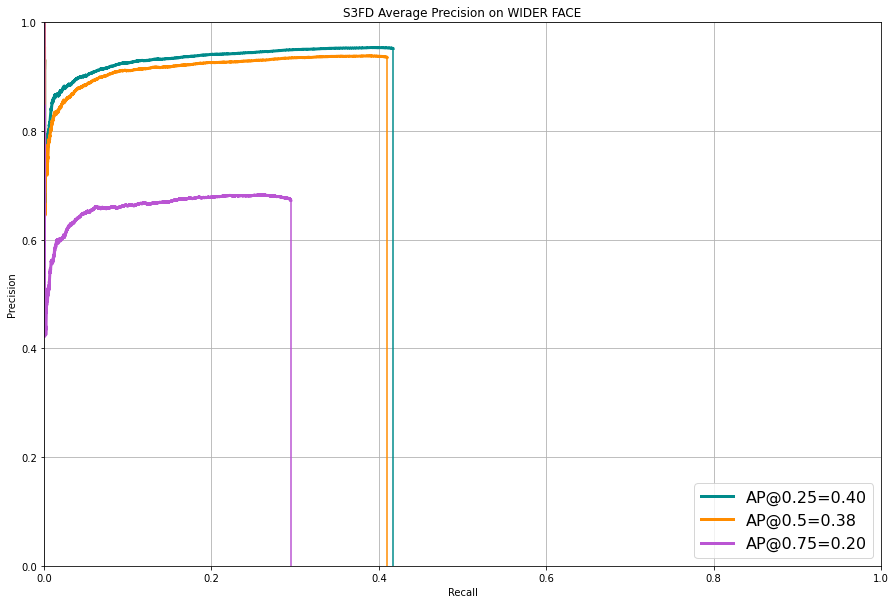

In [19]:
plot_pr(df_ap, 'S3FD Average Precision on WIDER FACE')

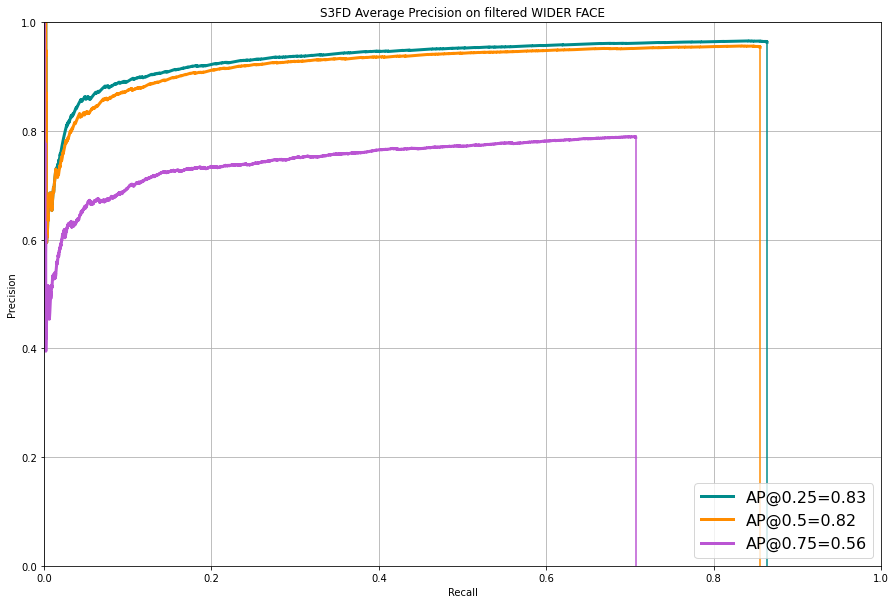

In [20]:
plot_pr(df_ap_filtered, 'S3FD Average Precision on filtered WIDER FACE')

# S3FD Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class S3fdDetector(Detector):
    def __init__(self):
        self.detector = FaceDetectionEngine(weights_path="./models/s3fd/s3fd_convert.pth")
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Running on device: {}'.format(device))
        
    def detect(self, image):
        preds, scores = self.detector.predict(image, dilate_bbox=False)

        return preds, scores

s3fd = S3fdDetector()

Running on device: cpu


In [24]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=s3fd,
    results_folder="s3fd",
    save_videos=True
)

Frames: [====================] 100% [164/164], Videos: [216/216]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.65
Mean detection percentage of faces in all videos: 93.45
Mean confidence of boxes in all videos: 285.79
Mean inference time for all frames: 1602.16ms
